In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions import Categorical
from IPython.display import clear_output

In [2]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('episode %s. reward: %s' % (frame_idx, np.mean(rewards[-100:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

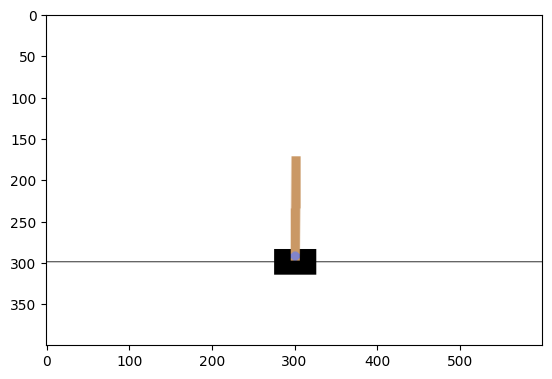

In [4]:
env = gym.make('CartPole-v1',render_mode = 'rgb_array')
state,info = env.reset()
plt.imshow(env.render())
plt.show()

In [5]:
class A_C(nn.Module):
    def __init__(self, state_shape,n_actions):
        super(A_C,self).__init__()
        
        self.f = nn.Sequential(
            nn.Linear(state_shape,64),
            nn.ReLU(),
            nn.Linear(64,64),
            nn.ReLU()
        )
        self.critic = nn.Linear(64,1)
        self.actor = nn.Linear(64,n_actions)
        
    def forward(self,x):
        x = self.f(x)
        value = self.critic(x)
        action_prob = F.softmax(self.actor(x),dim=-1)
        pmf = Categorical(action_prob)
        return pmf,value

In [6]:
Agent = A_C(4,2).to(device)
optimizer = torch.optim.Adam(Agent.parameters(),lr = 5e-4)

In [7]:
env_2 = gym.make('CartPole-v1',render_mode = 'rgb_array')

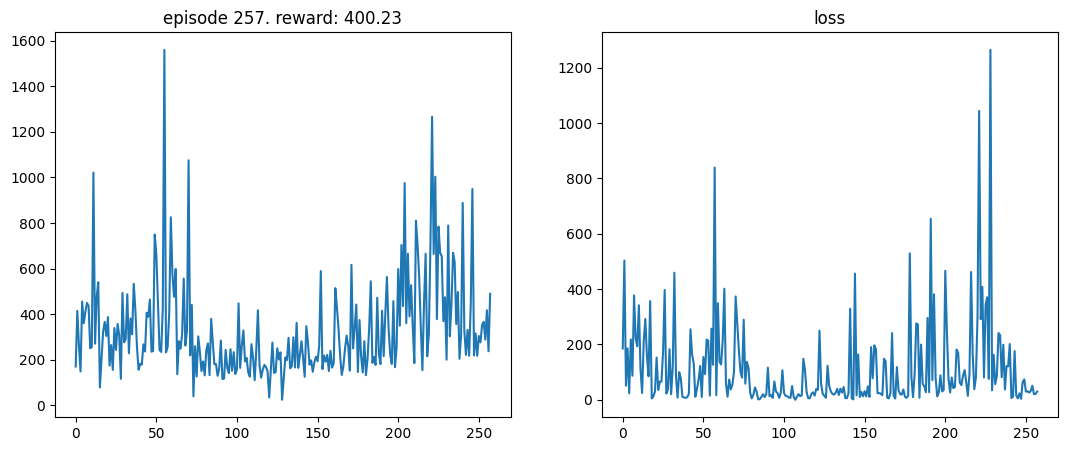

Solved


In [9]:
n_steps = 1000
episods_rewards = []
losses = []
for i in range(n_steps):
    state,info = env.reset()
    returns = []
    rewards = []
    values = []
    log_probs = []
    dones = []
    entropy = 0
    
    Agent.train()
    while True:
        state = torch.from_numpy(state).unsqueeze(dim=0).to(device)
        pmf,value = Agent(state)
        action = pmf.sample()
        next_state,reward,done,_,info = env.step(action.item())
        log_prob = pmf.log_prob(action)
        
        if done:
            break
        rewards.append(reward)
        values.append(value)
        dones.append(1-done)
        log_probs.append(log_prob)
        state = next_state
        
    
    log_probs = torch.cat(log_probs)
    g = 0
    for r in rewards[::-1]:
        g = r + 0.99 * g
        returns.insert(0,g)
    
    returns = torch.tensor(returns).detach().to(device)
    returns = (returns - returns.mean())/returns.std()
    
    advantage = []
    g = 0
    next_value = 0
    
    for r,v in zip(rewards[::-1],values[::-1]):
        delta = r + 0.99 * next_value - v
        g = delta + g * 0.99 * 0.95
        next_value = v
        advantage.insert(0,g)
    
    advantage = torch.tensor(advantage).detach().to(device)
    advantage = (advantage - advantage.mean())/advantage.std()
    values = torch.cat(values).squeeze(dim=1)
    
    
    actor_loss = -(advantage * log_probs).sum()
    critic_loss = (returns - values).pow(2).sum()
        
    optimizer.zero_grad()
    loss = actor_loss + critic_loss
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    
            

    test_state,info = env_2.reset()
    test_rewards = 0
    Agent.eval()
    with torch.inference_mode():
        
        while True:
            test_state = torch.from_numpy(test_state).unsqueeze(dim=0).to(device)
            pmf,value = Agent(test_state)
            test_action = pmf.sample()
            test_next_state,test_reward,test_done,_,info = env_2.step(test_action.item())
            if test_done:
                break
            test_state = test_next_state
            test_rewards+= test_reward
        episods_rewards.append(test_rewards)
            
    plot(i,episods_rewards,losses)
    if np.mean(episods_rewards[-100:]) > 400:
        print('Solved')
        break
    